In [8]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import os
import math
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
import datetime
from multiprocessing import Process, Queue
import time
from tqdm import tqdm


# load dataset

In [9]:
##Loading data
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class DIV2K(Dataset):
    def __init__(self, root_dir, train=True, transform=None, lr_transform=None, only_lr=False):
        self.root_dir = root_dir
        self.transform = transform
        self.lr_transform = lr_transform
        self.train = train
        self.only_lr = only_lr
        self.hr_image_paths, self.lr_image_paths = self._load_image_paths()

    def _load_image_paths(self):
        if self.train:
            hr_dir_name = 'DIV2K_train_HR'
        else:
            hr_dir_name = 'DIV2K_valid_HR'

        hr_dir_path = os.path.join(self.root_dir, hr_dir_name)
        lr_dir_path = os.path.join(self.root_dir, hr_dir_name)
        
        lr_image_paths = sorted([os.path.join(lr_dir_path, fname) for fname in os.listdir(lr_dir_path) if fname.endswith('.png')])
        
        if not self.only_lr:
            hr_image_paths = sorted([os.path.join(hr_dir_path, fname) for fname in os.listdir(hr_dir_path) if fname.endswith('.png')])
            print(f"HR images: {len(hr_image_paths)}, LR images: {len(lr_image_paths)}")
        else:
            hr_image_paths = [None] * len(lr_image_paths)
            print(f"LR images: {len(lr_image_paths)} (HR images not loaded)")
      
        return hr_image_paths, lr_image_paths

    def __len__(self):
        return len(self.lr_image_paths)

    def __getitem__(self, idx):
        lr_img_path = self.lr_image_paths[idx]
        lr_image = Image.open(lr_img_path).convert('RGB')
        
        if self.lr_transform:
            lr_image = self.lr_transform(lr_image)
        else:
            lr_image = transforms.ToTensor()(lr_image)
        
        if not self.only_lr:
            hr_img_path = self.hr_image_paths[idx]
            hr_image = Image.open(hr_img_path).convert('RGB')
            if self.transform:
                hr_image = self.transform(hr_image)
            else:
                hr_image = transforms.ToTensor()(hr_image)
            return lr_image, hr_image
        else:
            return lr_image
        


# Define transformations
transform1 = transforms.Compose([
    transforms.Resize((512,512)),  # Resize images to 128
    transforms.ToTensor(),
])
transform2 = transforms.Compose([
    transforms.Resize((128,128)),  # Resize images to 32
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


# Load training dataset
train_dataset = DIV2K(root_dir='', train=True, transform=transform1, lr_transform=transform2)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Load validation dataset
val_dataset = DIV2K(root_dir='', train=False, transform=transform1, lr_transform=transform2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# # Load test dataset
test_dataset = DIV2K(root_dir='Test', train=False, transform=transform1, lr_transform=transform2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

HR images: 800, LR images: 800
HR images: 100, LR images: 100
HR images: 5, LR images: 5


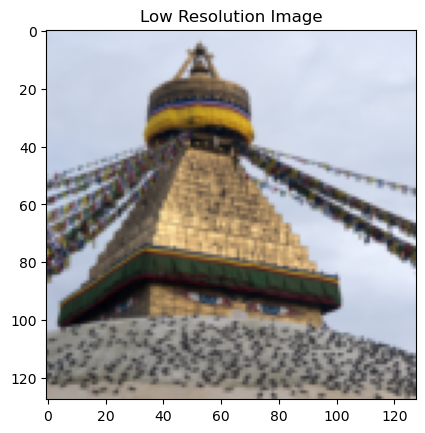

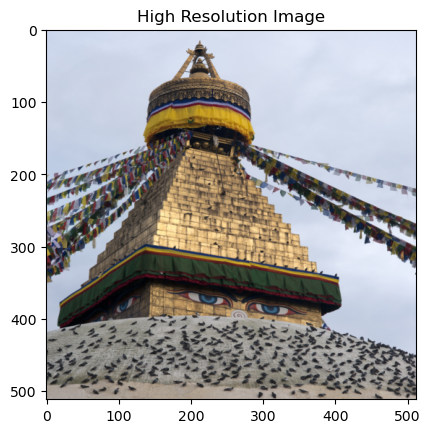

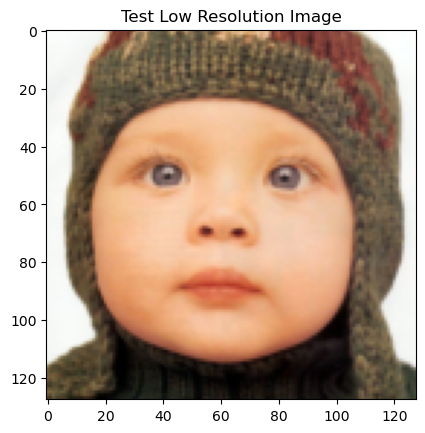

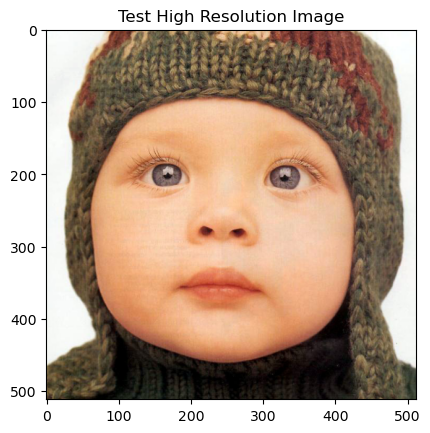

In [10]:

import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Function to denormalize and display an image
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()

# Get a batch of images

dataiter = iter(train_loader)
lr_images, hr_images = next(dataiter)

dataiter2 = iter(test_loader)
lr_images2, hr_images2 = next(dataiter2)

# Show the first low-resolution and high-resolution images
imshow(lr_images[0], title='Low Resolution Image')
imshow(hr_images[0], title='High Resolution Image')
imshow(lr_images2[0], title='Test Low Resolution Image')
imshow(hr_images2[0], title='Test High Resolution Image')

In [11]:
print("Low-resolution image shape:", lr_images[1].shape)
print("Super-resolved image shape:", hr_images[1].shape)

Low-resolution image shape: torch.Size([3, 128, 128])
Super-resolved image shape: torch.Size([3, 512, 512])


## Model Architecture

In [12]:
import torch
import torch.nn as nn

class MeanShift(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean=(0.4488, 0.4371, 0.4040),rgb_std=(0.229, 0.224, 0.225), sign=-1):
        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1) / std.view(3, 1, 1, 1)
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean) / std
        for p in self.parameters():
            p.requires_grad = False

class ResBlock(nn.Module):
    def __init__(self, conv, n_feats, kernel_size, bias=True, bn=False, act=nn.ReLU(True), res_scale=1):
        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feats, n_feats, kernel_size, bias=bias))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if i == 0:
                m.append(act)
        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x
        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feats, bn=False, act=False, bias=True):
        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feats, 4 * n_feats, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn:
                    m.append(nn.BatchNorm2d(n_feats))
                if act == 'relu':
                    m.append(nn.ReLU(True))
                elif act == 'prelu':
                    m.append(nn.PReLU(n_feats))
        elif scale == 3:
            m.append(conv(n_feats, 9 * n_feats, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if act == 'relu':
                m.append(nn.ReLU(True))
            elif act == 'prelu':
                m.append(nn.PReLU(n_feats))
        else:
            raise NotImplementedError
        super(Upsampler, self).__init__(*m)

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=(kernel_size//2), bias=bias)


class EDSR(nn.Module):
    def __init__(self, n_resblocks, n_feats, scale, n_colors, res_scale, rgb_range, conv=default_conv):
        super(EDSR, self).__init__()

        kernel_size = 3 
        act = nn.ReLU(True)

        self.sub_mean = MeanShift(rgb_range)
        self.add_mean = MeanShift(rgb_range, sign=1)

        # define head module
        m_head = [conv(n_colors, n_feats, kernel_size)]

        # define body module
        m_body = [
            ResBlock(
                conv, n_feats, kernel_size, act=act, res_scale=res_scale
            ) for _ in range(n_resblocks)
        ]
        m_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        m_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, n_colors, kernel_size)
        ]

        self.head = nn.Sequential(*m_head)
        self.body = nn.Sequential(*m_body)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
       x = self.sub_mean(x)
       x = self.head(x)
    
       res = self.body(x)
       res += x
    
       x = self.tail(res)
       x = self.add_mean(x)

       return x


## Training Loop

In [13]:
#quantize output image 
def quantize(img, rgb_range):
    pixel_range = 255 / rgb_range
    return img.mul(pixel_range).clamp(0, 255).round().div(pixel_range)
## Define PSNR
def calc_psnr(sr, hr, scale, rgb_range):
    diff = (sr - hr) / rgb_range
    shave = scale + 6
    valid = diff[..., shave:-shave, shave:-shave]
    mse = valid.pow(2).mean()
    return -10 * torch.log10(mse)

def calculate_ssim(sr, hr, window_size=11, data_range=1.0):
    # Convert tensors to numpy arrays
    sr_np = sr.cpu().numpy().transpose(0, 2, 3, 1)
    hr_np = hr.cpu().numpy().transpose(0, 2, 3, 1)
    
    # Calculate SSIM for each image in the batch
    ssim_values = [
        ssim(sr_np[i], hr_np[i], win_size=window_size, channel_axis=-1, data_range=data_range)
        for i in range(sr_np.shape[0])
    ]
    return sum(ssim_values) / len(ssim_values)
    
## caculate PI
def calculate_pi(ssim_value, psnr_value):
    # Example PI calculation, adjust as needed
    return 0.5 * (10 - ssim_value) + 0.5 * (100 - psnr_value)




In [7]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F


def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.to(device)
    
    # Lists to store metrics
    psnr_list = []
    ssim_list = []
    pi_list = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for lr, hr in train_loader:
            lr, hr = lr.to(device), hr.to(device)
            
            # Forward pass
            sr = model(lr)
            loss = criterion(sr, hr)


           # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        running_psnr = 0.0
        running_ssim = 0.0
        running_pi = 0.0
        with torch.no_grad():
            for lr, hr in val_loader:
                lr, hr = lr.to(device), hr.to(device)
                
                # Forward pass
                sr = model(lr)
                loss = criterion(sr, hr)
                
                running_val_loss += loss.item()
                # Calculate PSNR
                psnr = calc_psnr(sr, hr, scale, rgb_range)
                running_psnr += psnr.item()
                
                # Calculate SSIM
                ssim_value = calculate_ssim(sr, hr)
                running_ssim += ssim_value
                
                # Calculate PI
                pi_value = calculate_pi(ssim_value, psnr.item())
                running_pi += pi_value
        
        avg_val_loss = running_val_loss / len(val_loader)
        avg_psnr = running_psnr / len(val_loader)
        avg_ssim = running_ssim / len(val_loader)
        avg_pi = running_pi / len(val_loader)
        
        # Append metrics to lists
        psnr_list.append(avg_psnr)
        ssim_list.append(avg_ssim)
        pi_list.append(avg_pi)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}, PI: {avg_pi:.4f}')
    
    return psnr_list, ssim_list, pi_list


# Initialize the model, criterion, optimizer
n_resblocks = 32
n_feats = 256
scale = 4
n_colors = 3
res_scale = 0.1
rgb_range = 1

model = EDSR(
    n_resblocks=n_resblocks,
    n_feats=n_feats,
    scale=scale,
    n_colors=n_colors,
    res_scale=res_scale,
    rgb_range=rgb_range
)

# Define the L1 loss function
criterion = nn.L1Loss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_and_validate(model, train_loader, val_loader, criterion, optimizer)


Epoch [1/20], Training Loss: 0.2753, Validation Loss: 0.1363, PSNR: 17.05 dB, SSIM: 0.4544, PI: 46.2488
Epoch [2/20], Training Loss: 0.0971, Validation Loss: 0.0910, PSNR: 19.24 dB, SSIM: 0.6009, PI: 45.0787
Epoch [3/20], Training Loss: 0.0745, Validation Loss: 0.0760, PSNR: 19.96 dB, SSIM: 0.6119, PI: 44.7162
Epoch [4/20], Training Loss: 0.0812, Validation Loss: 0.0623, PSNR: 21.41 dB, SSIM: 0.6944, PI: 43.9471
Epoch [5/20], Training Loss: 0.0646, Validation Loss: 0.0684, PSNR: 20.86 dB, SSIM: 0.6881, PI: 44.2241
Epoch [6/20], Training Loss: 0.0663, Validation Loss: 0.0588, PSNR: 21.65 dB, SSIM: 0.6989, PI: 43.8241
Epoch [7/20], Training Loss: 0.0651, Validation Loss: 0.0671, PSNR: 20.94 dB, SSIM: 0.6688, PI: 44.1931
Epoch [8/20], Training Loss: 0.0588, Validation Loss: 0.0646, PSNR: 21.20 dB, SSIM: 0.7061, PI: 44.0449
Epoch [9/20], Training Loss: 0.0622, Validation Loss: 0.0683, PSNR: 20.84 dB, SSIM: 0.7136, PI: 44.2222
Epoch [10/20], Training Loss: 0.0675, Validation Loss: 0.0691, P

([17.04806900024414,
  19.241586978618916,
  19.955739974975586,
  21.41144092266376,
  20.863741654616135,
  21.65286636352539,
  20.94492061321552,
  21.204136041494515,
  20.841964134803185,
  20.860496227557842,
  22.141239899855393,
  21.27634620666504,
  21.402815451988808,
  21.991948641263523,
  21.963481169480545,
  22.3330387702355,
  22.34397051884578,
  22.330235261183518,
  21.91046318641076,
  22.1007263477032],
 [np.float32(0.45435554),
  np.float32(0.600949),
  np.float32(0.6118788),
  np.float32(0.694382),
  np.float32(0.68812835),
  np.float32(0.69892216),
  np.float32(0.6687798),
  np.float32(0.7060775),
  np.float32(0.71365),
  np.float32(0.6932103),
  np.float32(0.74691075),
  np.float32(0.73195136),
  np.float32(0.70857686),
  np.float32(0.73712575),
  np.float32(0.7490028),
  np.float32(0.7523461),
  np.float32(0.7502502),
  np.float32(0.7527519),
  np.float32(0.743401),
  np.float32(0.7483362)],
 [np.float32(46.248795),
  np.float32(45.07873),
  np.float32(44.71

In [8]:
# Save the model weights
torch.save(model.state_dict(), 'model_weights.pth')

## Plot result

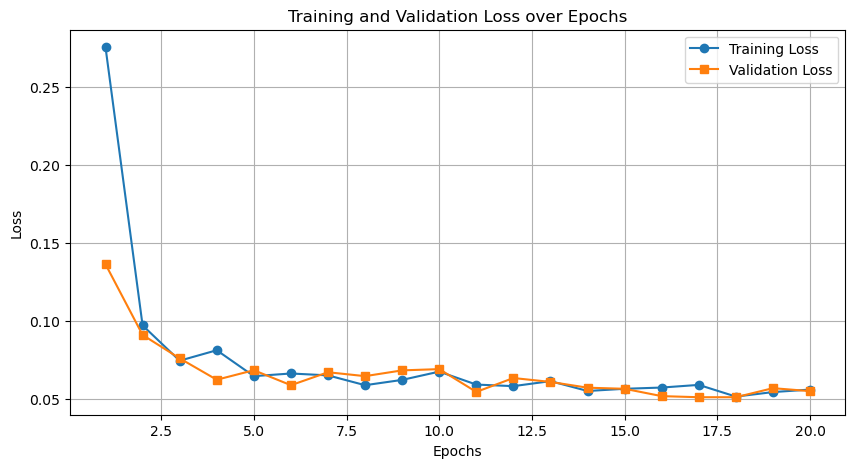

In [13]:
import matplotlib.pyplot as plt

training_loss = [
    0.2753, 0.0971, 0.0745, 0.0812, 0.0646, 0.0663, 0.0651, 0.0588, 0.0622, 0.0675,
    0.0592, 0.0582, 0.0614, 0.0551, 0.0565, 0.0573, 0.0590, 0.0515, 0.0544, 0.0560
]
validation_loss = [
    0.1363, 0.0910, 0.0760, 0.0623, 0.0684, 0.0588, 0.0671, 0.0646, 0.0683, 0.0691,
    0.0545, 0.0634, 0.0609, 0.0572, 0.0565, 0.0518, 0.0511, 0.0511, 0.0569, 0.0550
]

epochs = range(1, 21)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

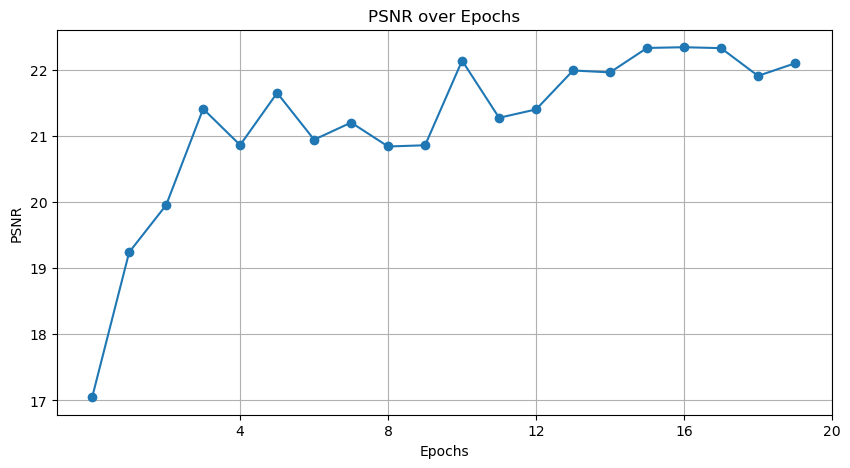

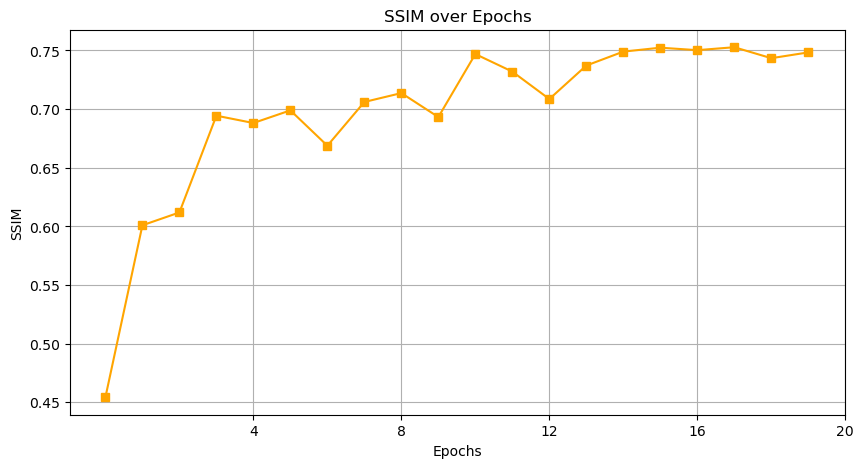

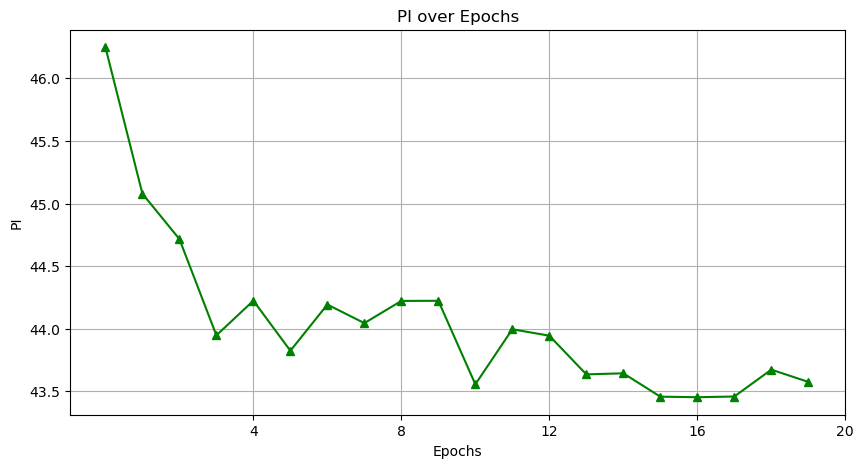

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
psnr_list = [17.04806900024414, 19.241586978618916, 19.955739974975586, 21.41144092266376, 20.863741654616135, 21.65286636352539, 20.94492061321552, 21.204136041494515, 20.841964134803185, 20.860496227557842, 22.141239899855393, 21.27634620666504, 21.402815451988808, 21.991948641263523, 21.963481169480545, 22.3330387702355, 22.34397051884578, 22.330235261183518, 21.91046318641076, 22.1007263477032]
ssim_list = [np.float32(0.45435554), np.float32(0.600949), np.float32(0.6118788), np.float32(0.694382), np.float32(0.68812835), np.float32(0.69892216), np.float32(0.6687798), np.float32(0.7060775), np.float32(0.71365), np.float32(0.6932103), np.float32(0.74691075), np.float32(0.73195136), np.float32(0.70857686), np.float32(0.73712575), np.float32(0.7490028), np.float32(0.7523461), np.float32(0.7502502), np.float32(0.7527519), np.float32(0.743401), np.float32(0.7483362)]
pi_list = [np.float32(46.248795), np.float32(45.07873), np.float32(44.71619), np.float32(43.947083), np.float32(44.224068), np.float32(43.824104), np.float32(44.19315), np.float32(44.044895), np.float32(44.22219), np.float32(44.223145), np.float32(43.555927), np.float32(43.995853), np.float32(43.94431), np.float32(43.63546), np.float32(43.64376), np.float32(43.45731), np.float32(43.452885), np.float32(43.458504), np.float32(43.673073), np.float32(43.575462)]

# Plot PSNR
plt.figure(figsize=(10, 5))
plt.plot(psnr_list, label='PSNR', marker='o')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('PSNR over Epochs')
plt.xticks([4, 8, 12, 16, 20], [4, 8, 12, 16, 20]) 
plt.grid(True)
plt.show()

# Plot SSIM
plt.figure(figsize=(10, 5))
plt.plot(ssim_list, label='SSIM', marker='s', color='orange')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.title('SSIM over Epochs')
plt.xticks([4, 8, 12, 16, 20], [4, 8, 12, 16, 20]) 
plt.grid(True)
plt.show()

# Plot PI
plt.figure(figsize=(10, 5))
plt.plot(pi_list, label='PI', marker='^', color='green')
plt.xlabel('Epochs')
plt.ylabel('PI')
plt.title('PI over Epochs')
plt.xticks([4, 8, 12, 16, 20], [4, 8, 12, 16, 20]) 
plt.grid(True)
plt.show()

## Test image

In [14]:
# Initialize the model, criterion, optimizer
n_resblocks = 32
n_feats = 256
scale = 4
n_colors = 3
res_scale = 0.1
rgb_range = 1

model = EDSR(
    n_resblocks=n_resblocks,
    n_feats=n_feats,
    scale=scale,
    n_colors=n_colors,
    res_scale=res_scale,
    rgb_range=rgb_range
)

# Define the L1 loss function
criterion = nn.L1Loss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  

EDSR(
  (sub_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (add_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (head): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (body): Sequential(
    (0): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09395228..1.0724617].


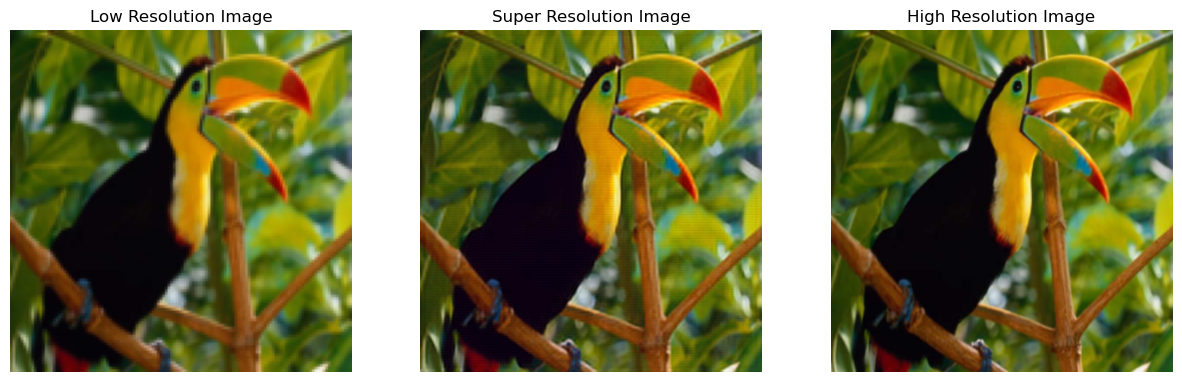

Test Loss: 0.0248, PSNR: 30.14 dB, SSIM: 0.8666, Perceptual Index: -5.5048


In [15]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def imshow_row(images, titles=None):
    """Display a list of images in a single row."""
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if titles is None:
        titles = [None] * num_images
    for ax, img, title in zip(axes, images, titles):
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        if title:
            ax.set_title(title)
        ax.axis('off')
    plt.show()
def test_model(model, test_loader, criterion):
    model.eval()
    running_test_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    with torch.no_grad():
        for lr, hr in test_loader:
            lr, hr = lr.to(device), hr.to(device)
            
            # Forward pass
            sr = model(lr)
            loss = criterion(sr, hr)
            
            running_test_loss += loss.item()
            
            # Calculate PSNR and SSIM
            psnr = calc_psnr(sr, hr, scale,rgb_range=1)
            ssim_value = calculate_ssim(sr, hr)
            running_psnr += psnr.item()
            running_ssim += ssim_value
            

    avg_test_loss = running_test_loss / len(test_loader)
    avg_psnr = running_psnr / len(test_loader)
    avg_ssim = running_ssim / len(test_loader)
    perceptual_index = (10 - avg_ssim) / 2 + (10 - avg_psnr) / 2

    # Visualize the first low-resolution, super-resolution, and high-resolution images
    imshow_row([lr[1].cpu(), sr[1].cpu(), hr[1].cpu()], 
               titles=['Low Resolution Image', 'Super Resolution Image', 'High Resolution Image'])
   

    print(f'Test Loss: {avg_test_loss:.4f}, PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}, Perceptual Index: {perceptual_index:.4f}')

    return avg_test_loss, avg_psnr, avg_ssim, perceptual_index

# Assuming test_loader is already defined
test_loss, test_psnr, test_ssim, test_perceptual_index = test_model(model, test_loader, criterion)

## Computational efficiency

In [16]:
import time

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
vdsr_params = count_parameters(model)
print(f"EDSR Parameters: {vdsr_params}")

def measure_inference_time(model, input_tensor):
    start_time = time.time()
    with torch.no_grad():
        model(input_tensor)
    end_time = time.time()
    return (end_time - start_time) * 1000  # Convert to milliseconds

# Create a sample input tensor
sample_input = torch.rand(1, 3, 128, 128)  # Adjust dimensions as needed
vdsr_time = measure_inference_time(model, sample_input)
print(f"EDSR Inference Time: {vdsr_time:.2f} ms")

from memory_profiler import memory_usage

def measure_memory_usage(model, input_tensor):
    # Define a function to run the model
    def run_model():
        with torch.no_grad():
            model(input_tensor)
    # Measure memory usage
    mem_usage = memory_usage(run_model)
    return max(mem_usage) - min(mem_usage)  # Return the difference in memory usage
sample_input = torch.rand(1, 3, 128, 128)

# Measure memory usage
memory_used = measure_memory_usage(model, sample_input)
print(f"Memory usage during inference: {memory_used:.2f} MB")

EDSR Parameters: 43089923
EDSR Inference Time: 4126.71 ms
Memory usage during inference: 512.48 MB
